In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import torch.optim as optim
import matplotlib.pyplot as plt

In [53]:
class Net(nn.Module):

    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 199) 
        #self.fc2 = nn.Linear(512, 512) 

        self.fc3 = nn.Linear(199, num_classes)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = (self.fc3(x))

        return x

model = Net(num_classes = 2)

In [54]:
mean0 = (1, 1)
cov0 = [[1, 0], [0, 1]]

mean1 = (-1, -1)
cov1 = [[1, 0], [0, 1]]

data0 = np.random.multivariate_normal(mean0, cov0, 1000)
data1 = np.random.multivariate_normal(mean1, cov1, 1000)

dataset = [(torch.Tensor(point), torch.LongTensor([0])) for point in data0]
dataset += [(torch.Tensor(point), torch.LongTensor([1])) for point in data1]

In [55]:
#uniform noise

mean0 = (1, 1)
sigma = 0.5
rho = sigma * sigma

cov0 = [[rho, 0], [0, rho]]

mean1 = (-1, -1)
cov1 = [[rho, 0], [0, rho]]

data0 = np.random.multivariate_normal(mean0, cov0, 1000)
data1 = np.random.multivariate_normal(mean1, cov1, 1000)

data = np.concatenate((data0, data1))
#data1[:,1] = data1[:,1] - 2
#print(data0)

input = torch.tensor(data).float()


label = [torch.LongTensor(np.random.binomial(1, 0.3, 1)) for point in data0]
label += [torch.LongTensor(np.random.binomial(1, 0.7, 1)) for point in data1]

label = torch.tensor(label)

In [56]:
#uniform noise

mean0 = (1, 1)
sigma = 0.5
rho = sigma * sigma

cov0 = [[rho, 0], [0, rho]]

mean1 = (-1, -1)
cov1 = [[rho, 0], [0, rho]]

data0 = np.random.multivariate_normal(mean0, cov0, 1000)
data1 = np.random.multivariate_normal(mean1, cov1, 1000)

data = np.concatenate((data0, data1))
#data1[:,1] = data1[:,1] - 2
#print(data0)

input = torch.tensor(data).float()


label = [torch.LongTensor(np.random.binomial(1, 0.3, 1)) for point in data0]
label += [torch.LongTensor(np.random.binomial(1, 0.7, 1)) for point in data1]

label = torch.tensor(label)

In [57]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):


    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])


                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                p.addcdiv_(exp_avg, denom, value=-step_size)


                update = (exp_avg / denom).view(-1)
                if update.shape[0] > 200:

                  y_number.append(update)
                  plt.hist(update.cpu())
                  plt.show()
                  plt.close()
                ###### Zhiyi THIS 'update' is the random variable we care about!

        return loss

step:  0


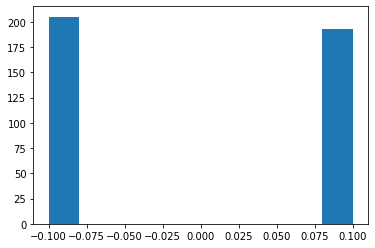

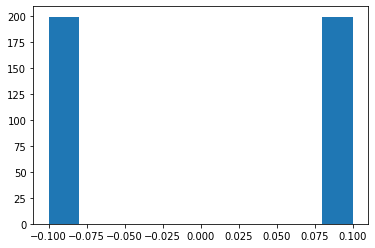

5.402523994445801 0.535 0.6017022132873535
step:  1


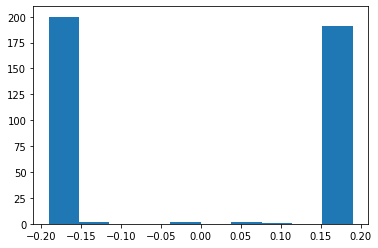

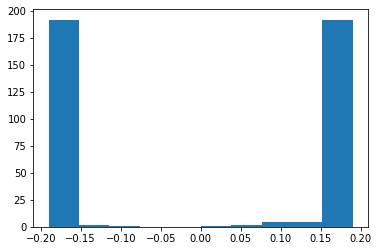

step:  2


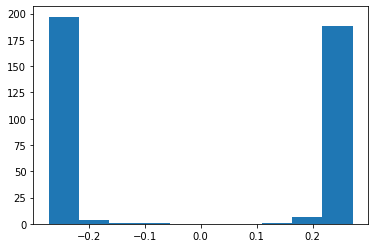

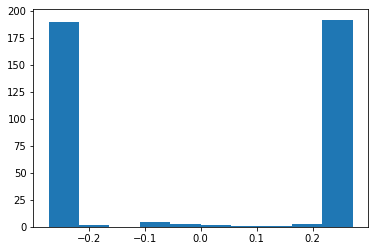

step:  3


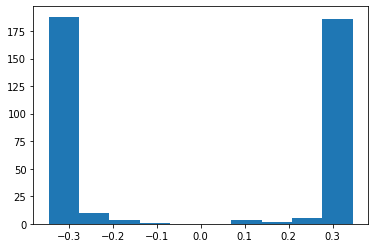

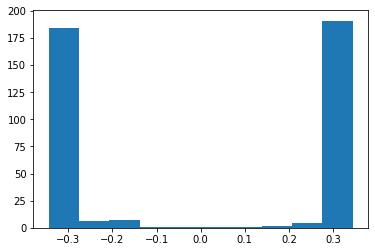

step:  4


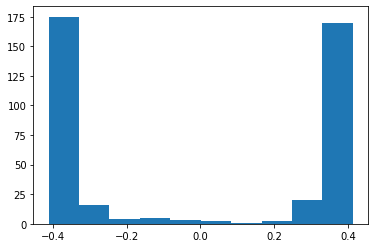

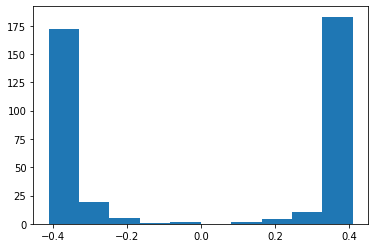

step:  5


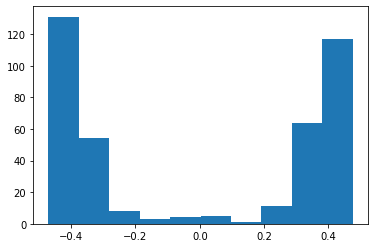

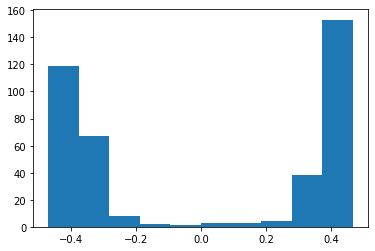

step:  6


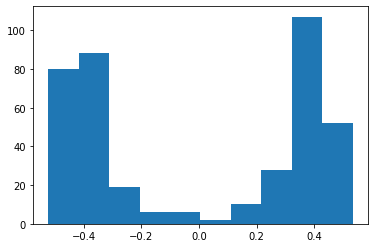

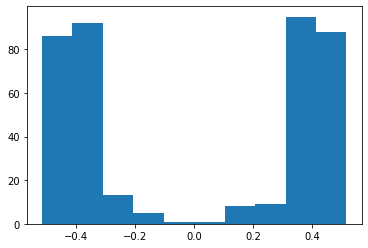

step:  7


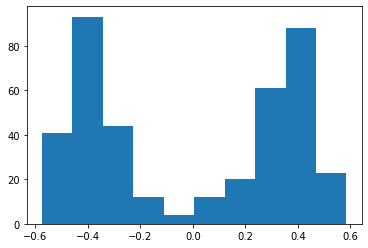

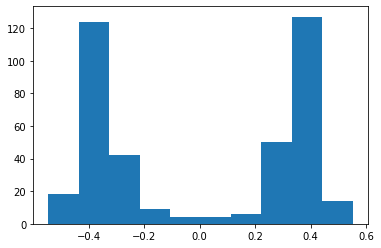

step:  8


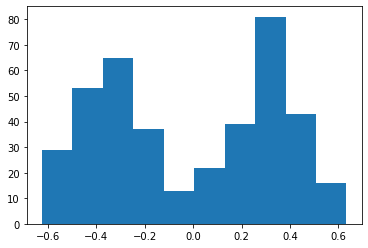

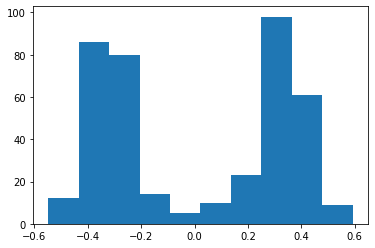

step:  9


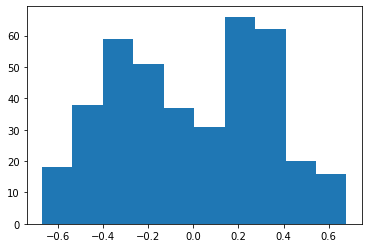

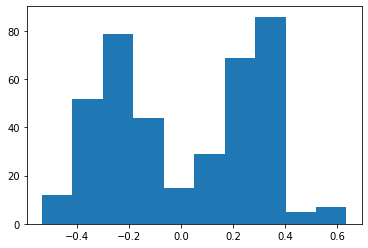

step:  10


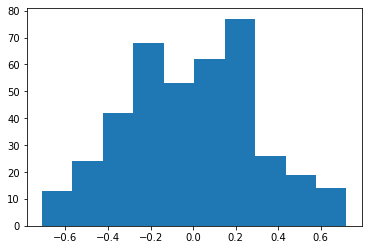

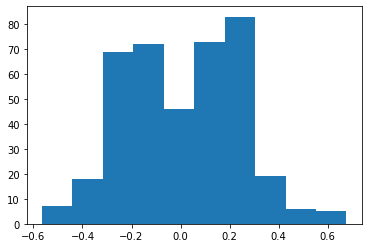

step:  11


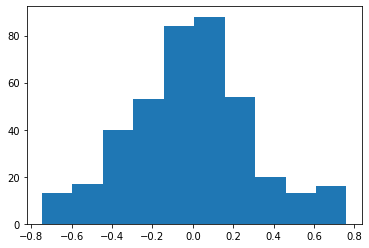

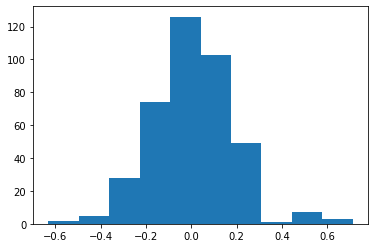

step:  12


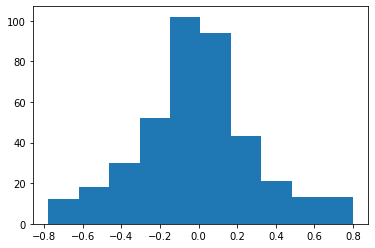

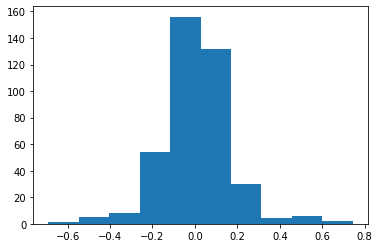

step:  13


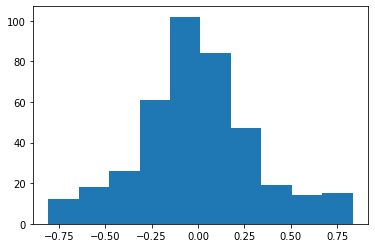

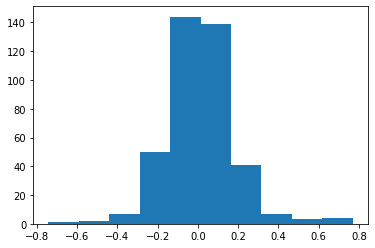

step:  14


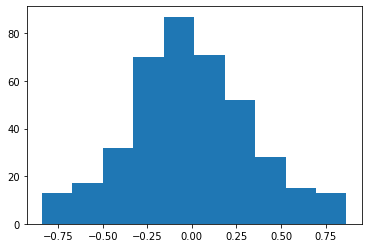

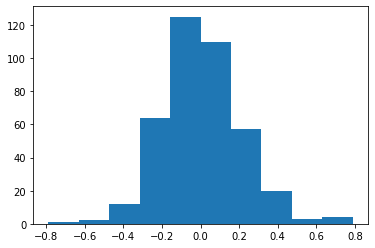

step:  15


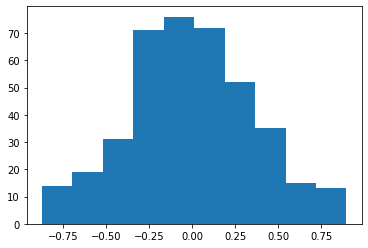

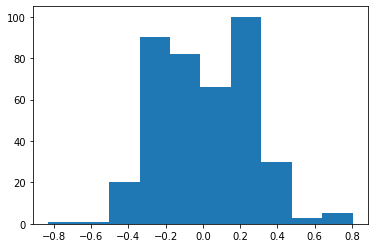

step:  16


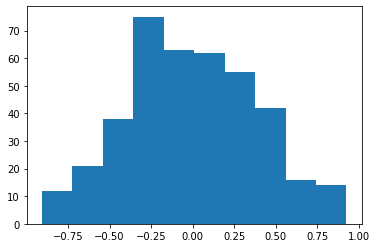

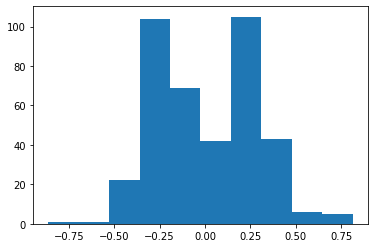

step:  17


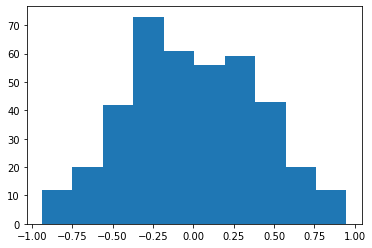

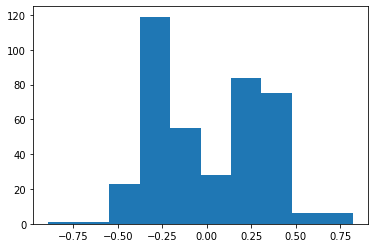

step:  18


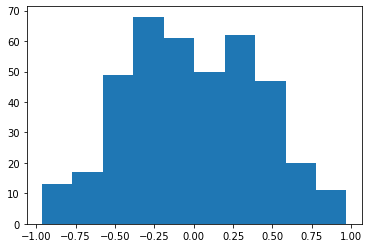

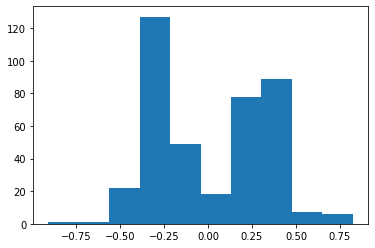

step:  19


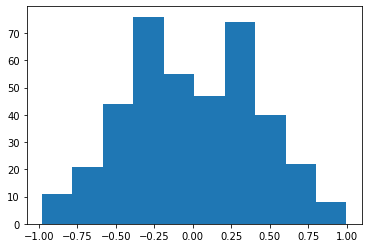

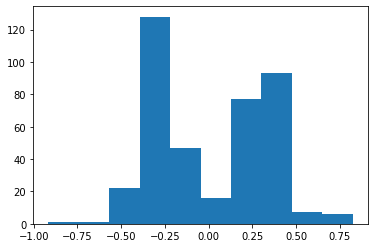

step:  20


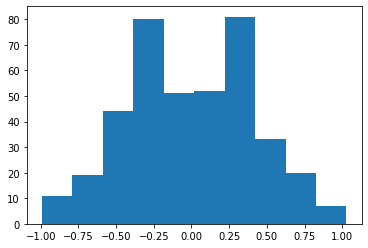

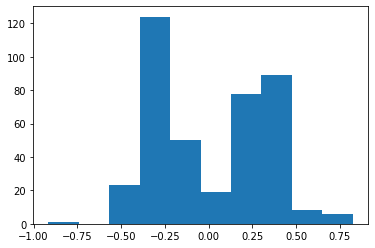

step:  21


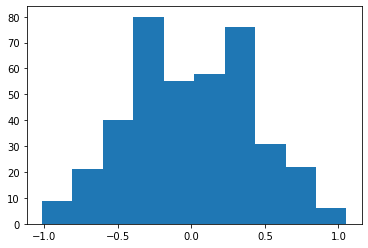

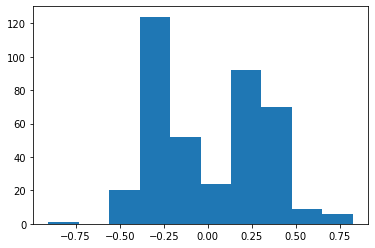

step:  22


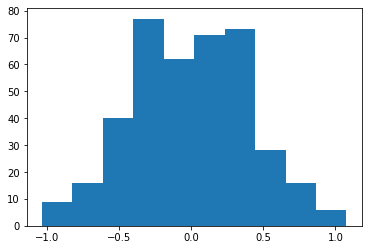

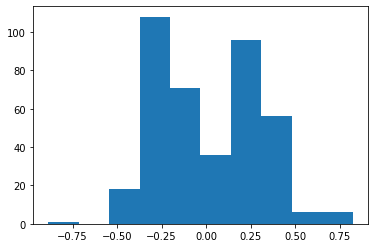

step:  23


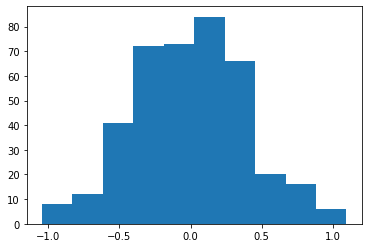

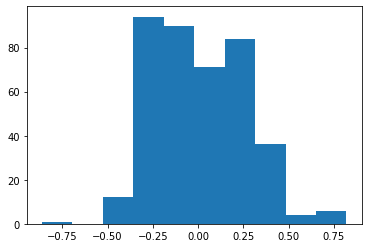

step:  24


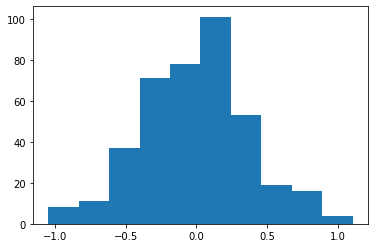

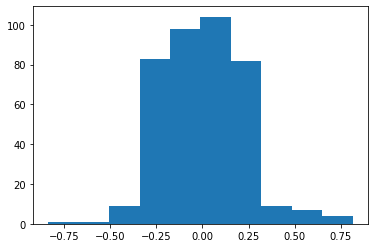

step:  25


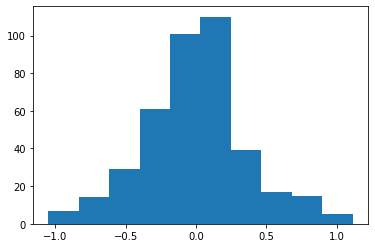

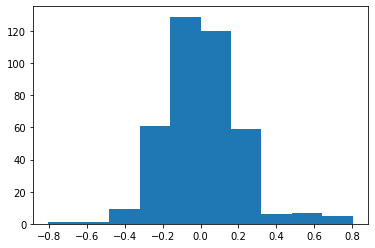

step:  26


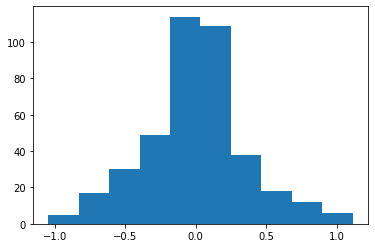

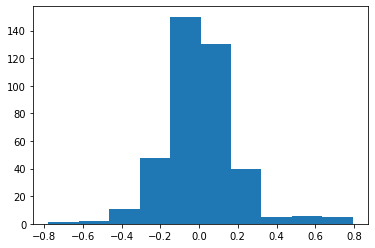

step:  27


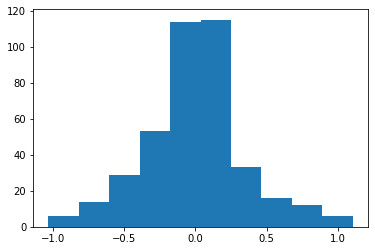

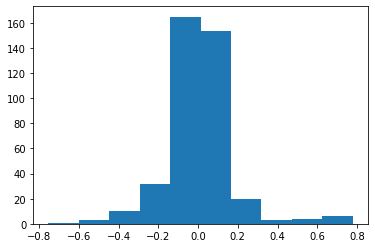

step:  28


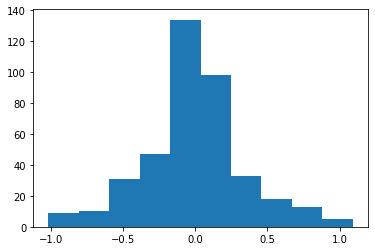

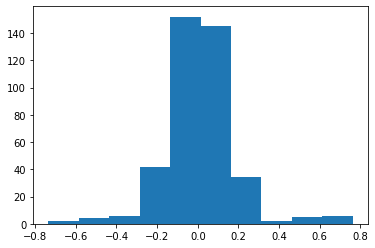

step:  29


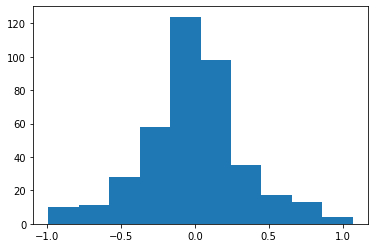

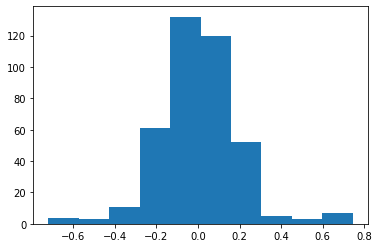

In [58]:
torch.manual_seed(1)



np.random.seed(1)
mean0 = (1, 1)
#sigma = 0.5
rho = sigma * sigma

cov0 = [[rho, 0], [0, rho]]

mean1 = (-1, -1)
cov1 = [[rho, 0], [0, rho]]

data0 = np.random.multivariate_normal(mean0, cov0, 100)
data1 = np.random.multivariate_normal(mean1, cov1, 100)

data = np.concatenate((data0, data1))
#data1[:,1] = data1[:,1] - 2
#print(data0)

input = torch.tensor(data).float().cuda()


label = [torch.LongTensor(np.random.binomial(1, 0.3, 1)) for point in data0]
label += [torch.LongTensor(np.random.binomial(1, 0.7, 1)) for point in data1]

label = torch.tensor(label).cuda()

model1 = Net(num_classes = 2).cuda()
optimizer = Adam(model1.parameters(), lr=1e-3)

model1.train()

#dataset_size = len(label)
#batchsize = 2


y_number = []
x_number = []
for i in range(30):
  print('step: ', i)
  x_number.append(i)
  optimizer.zero_grad()
  #batch_ind = np.random.randint(0, dataset_size, batchsize)

  #output = model1(input[batch_ind])
  output = model1(input)
  output = F.log_softmax(output, dim=0)

  #loss = F.nll_loss(output, label[batch_ind])
  loss = F.nll_loss(output, label)
  
  loss.backward()
  optimizer.step()
  if i % 100 == 0:
    #with torch.no_grad:
      #print(loss)
      #output = model1(input)
      #output = F.log_softmax(output, dim=0)
      #loss = F.nll_loss(output, label)
      
      #print(avgpred)
      pred = output.max(dim=1)[1]
      #print(pred == 0)
      avgpred1 = F.softmax(output, dim=1)[pred == 0].mean(dim=0)[0].item()
      avgpred2 = F.softmax(output, dim=1)[pred == 1].mean(dim=0)[1].item()
      avgpred = (avgpred1 + avgpred2)/2

      
      print(loss.item(), (pred == label).sum().float().item() / len(label), avgpred)
#correct[sigma] = (((pred == label).sum().float() / len(label)).item())
#losses[sigma] = loss.item()
#avg_pred[sigma] = avgpred

In [14]:
x_number
len(x_number)

100

In [15]:
y_number
len(y_number)

200

In [11]:
y_number_new = []
for i in range(len(y_number)):
    if i%2 ==1 :
        y_number_new.append(y_number[i])
    else:
        pass


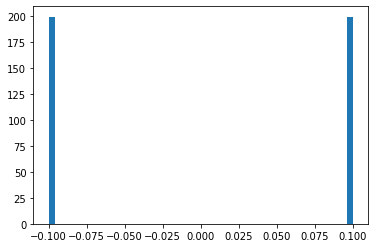

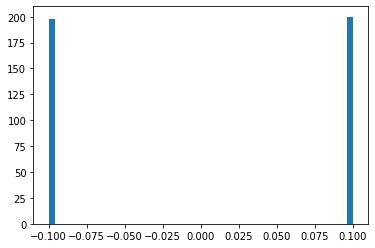

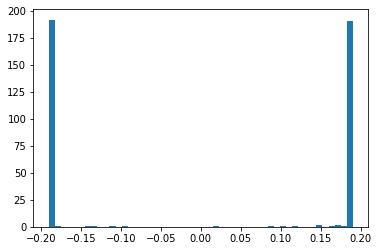

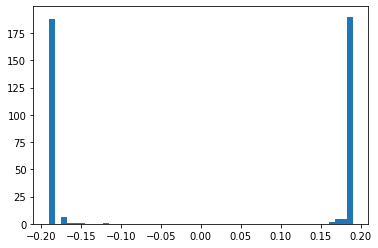

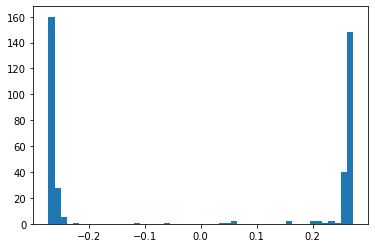

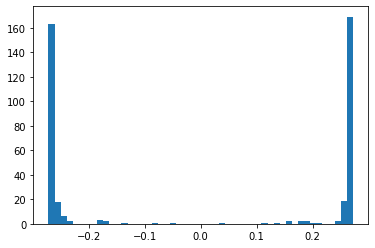

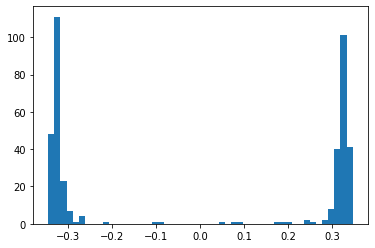

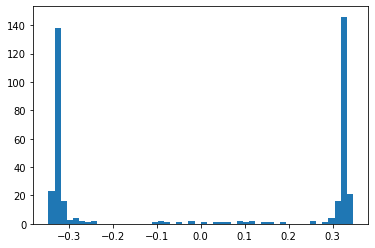

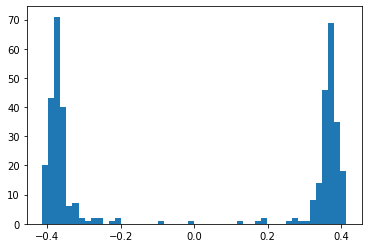

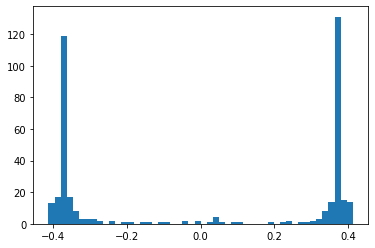

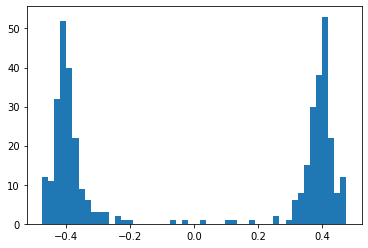

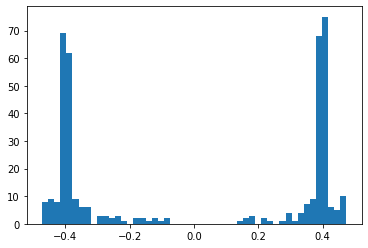

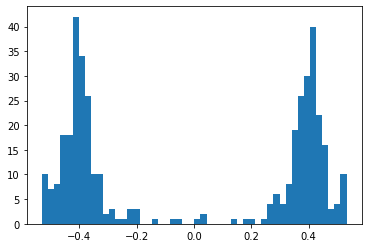

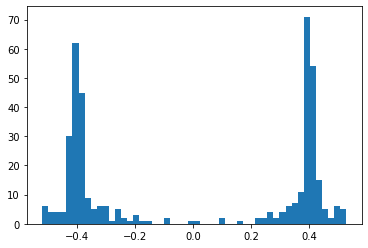

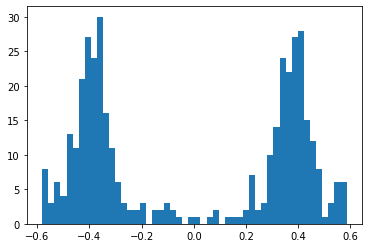

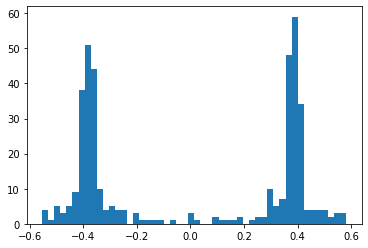

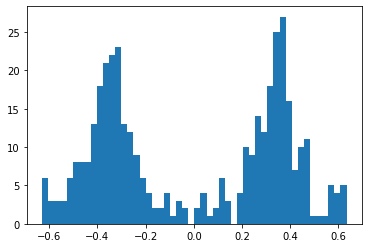

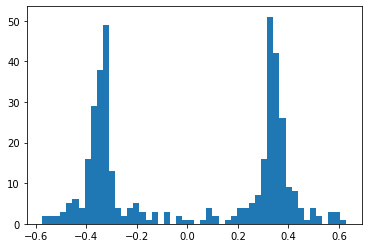

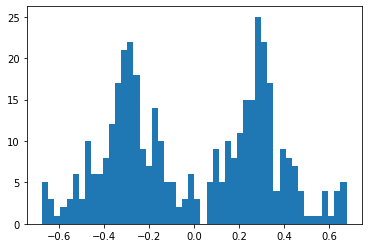

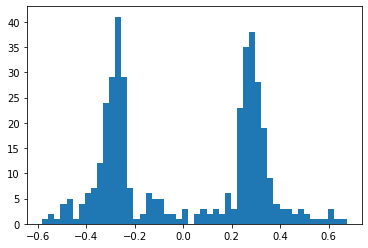

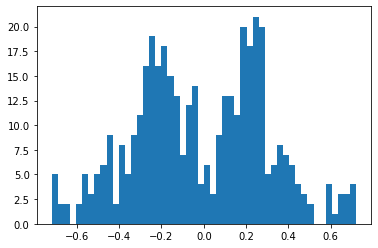

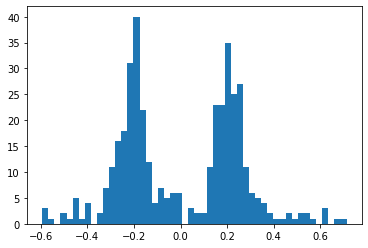

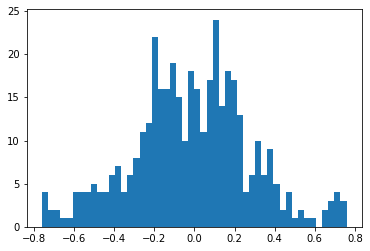

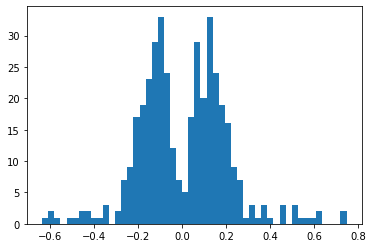

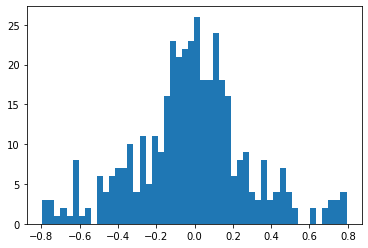

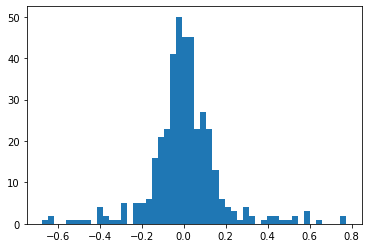

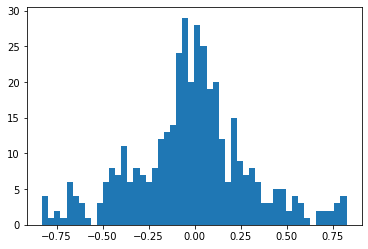

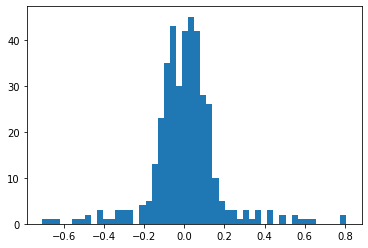

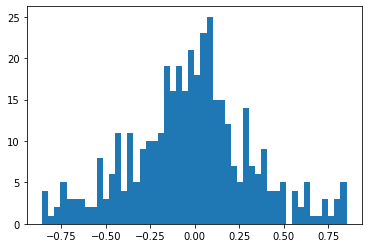

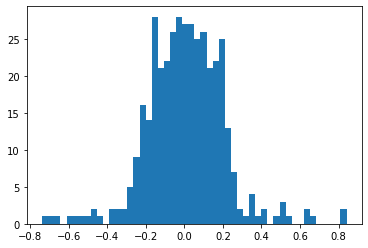

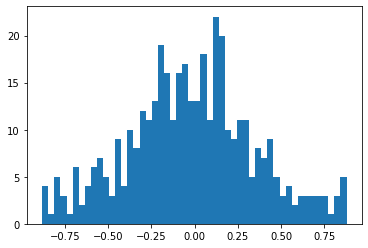

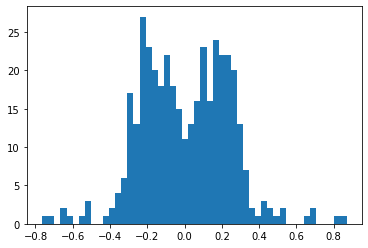

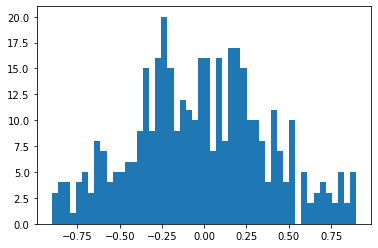

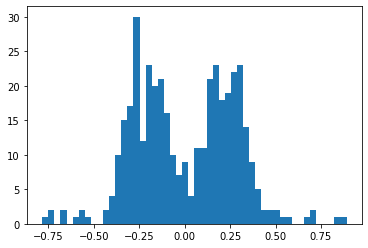

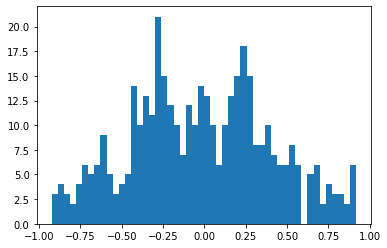

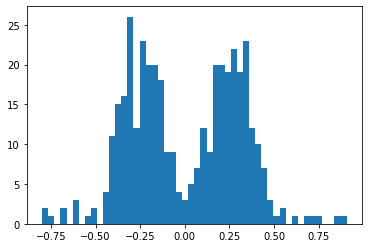

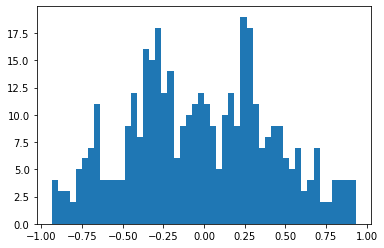

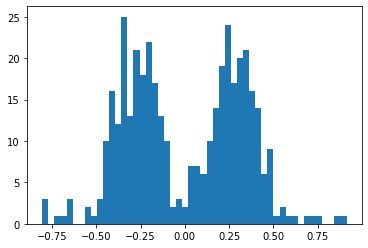

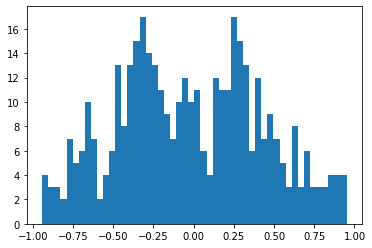

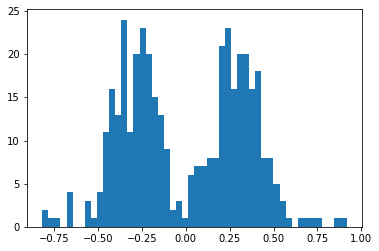

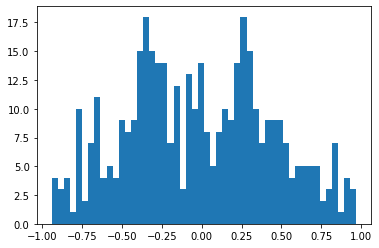

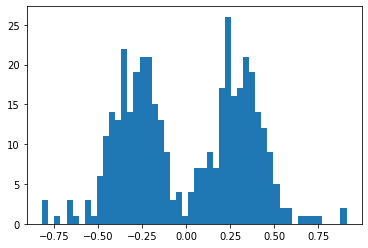

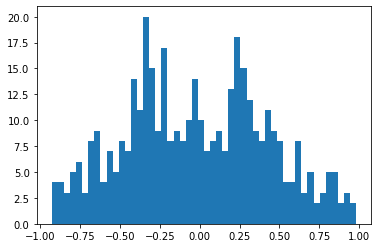

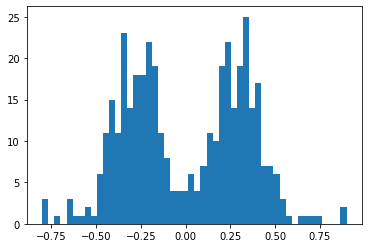

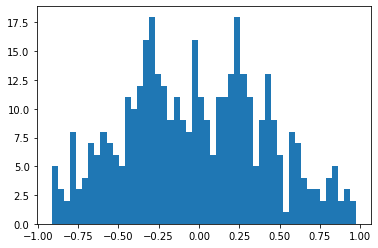

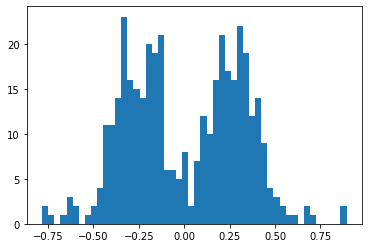

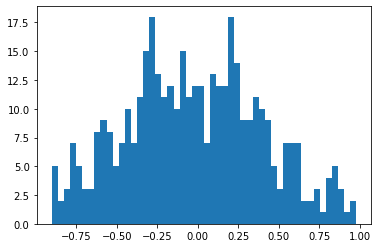

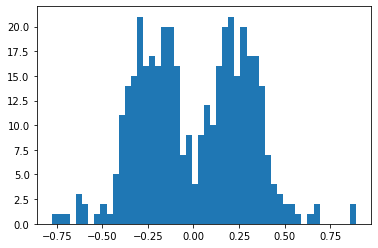

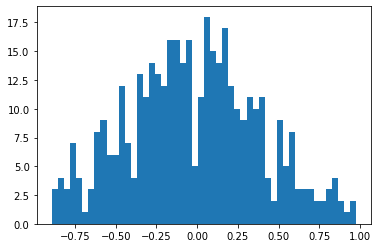

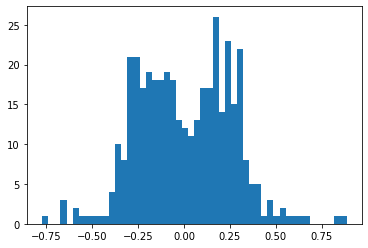

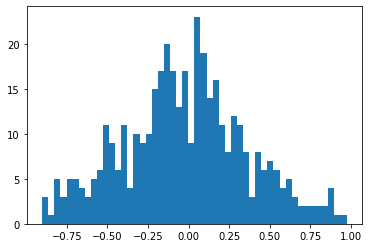

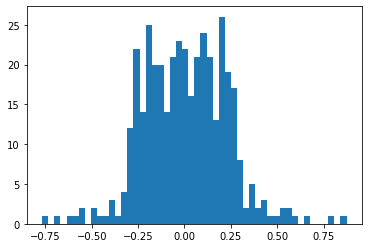

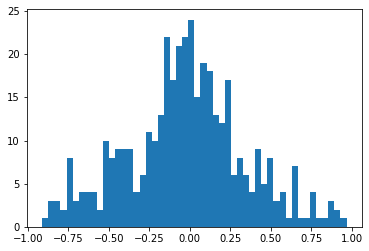

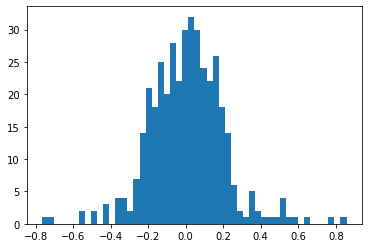

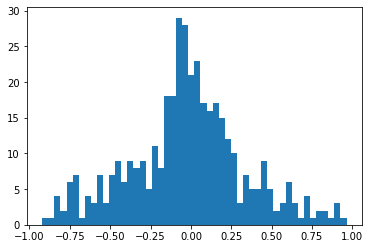

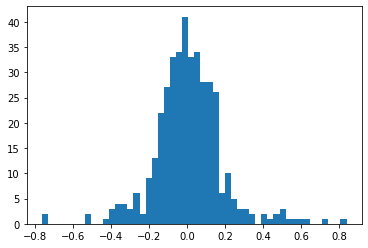

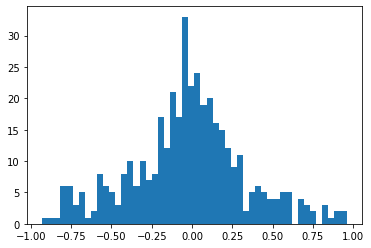

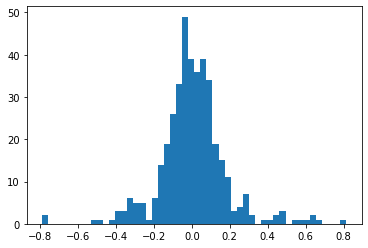

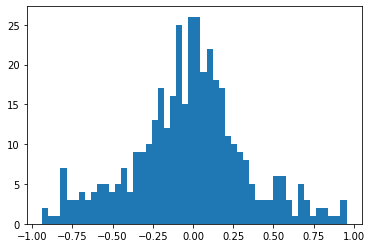

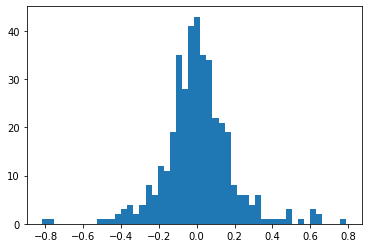

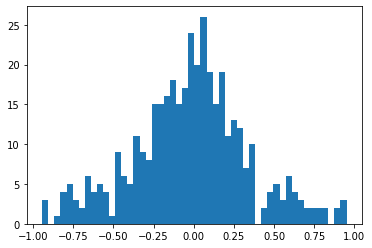

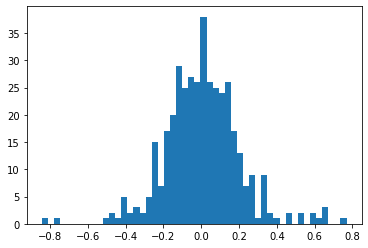

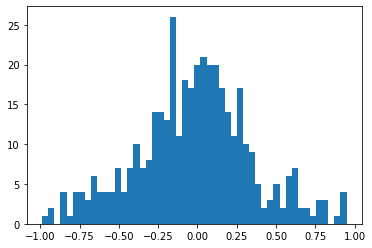

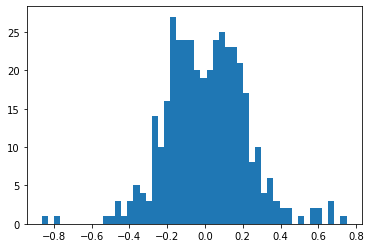

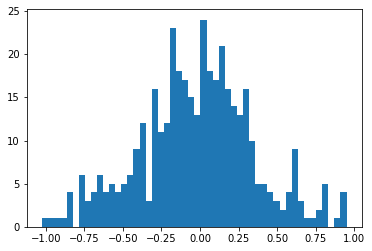

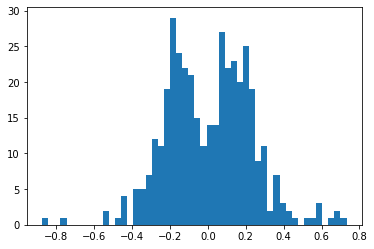

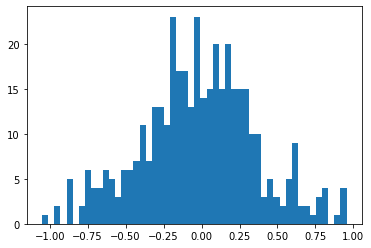

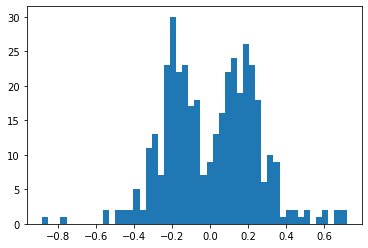

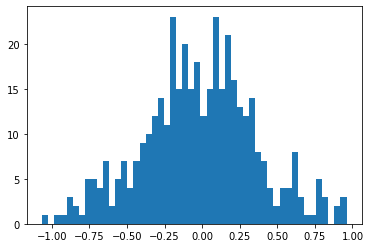

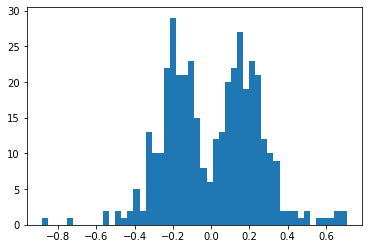

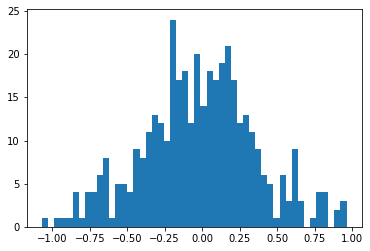

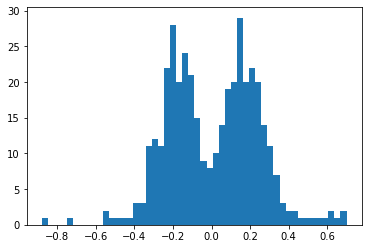

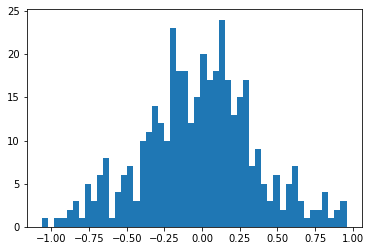

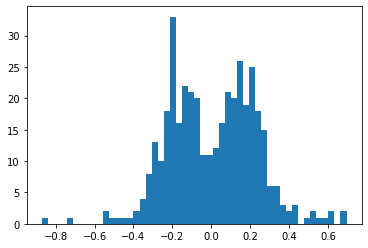

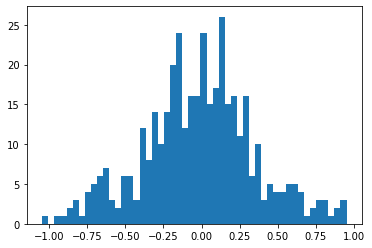

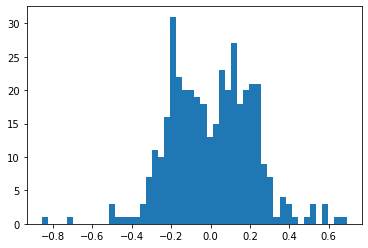

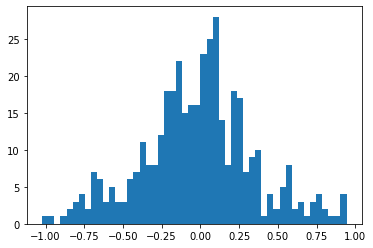

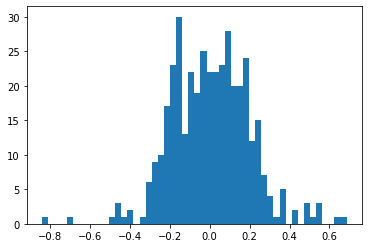

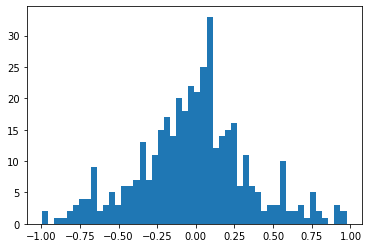

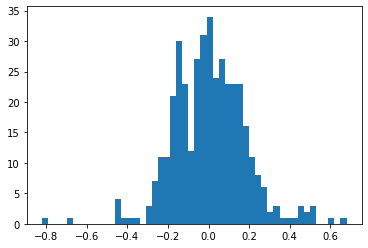

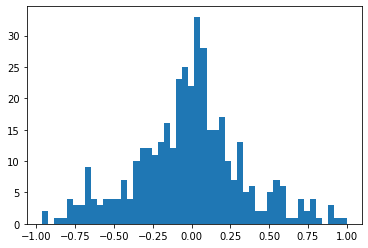

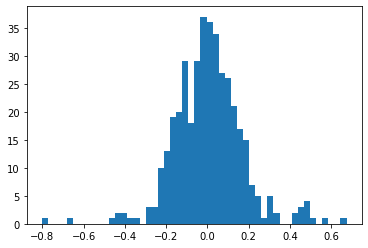

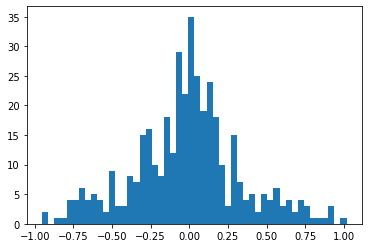

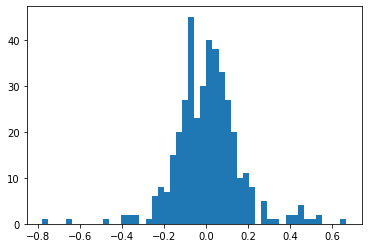

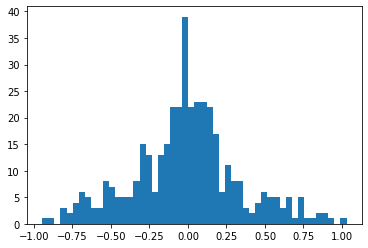

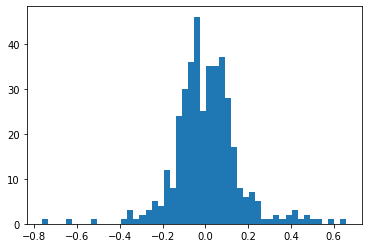

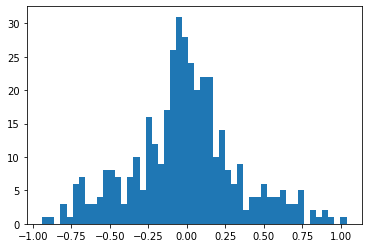

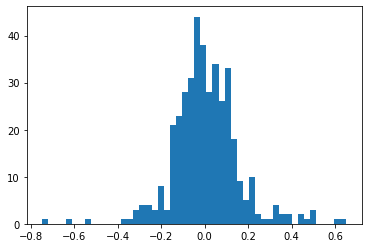

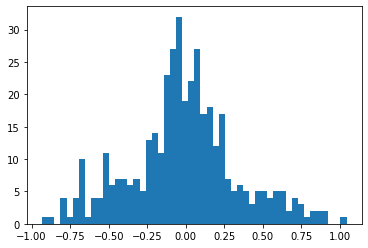

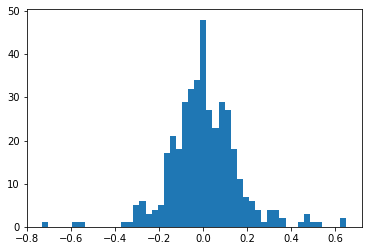

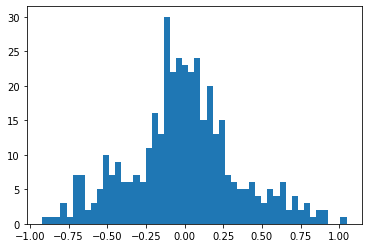

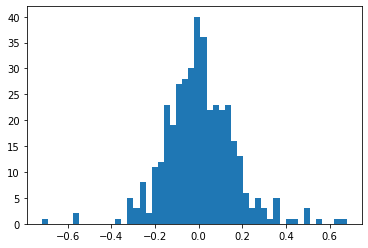

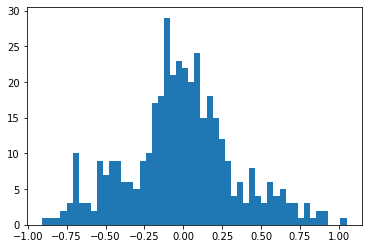

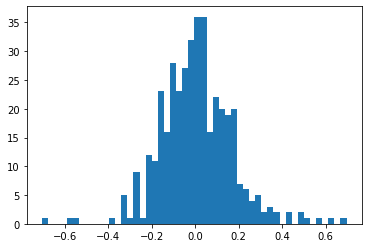

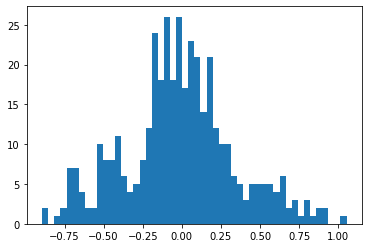

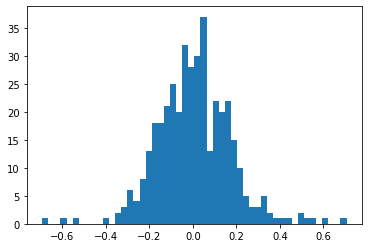

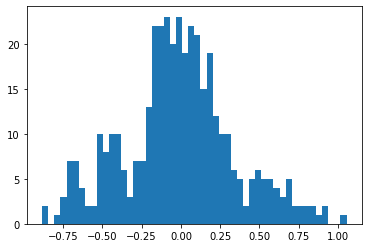

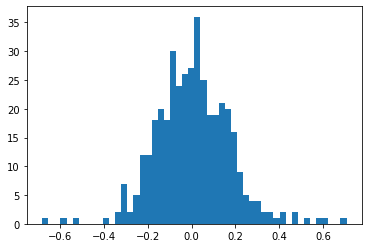

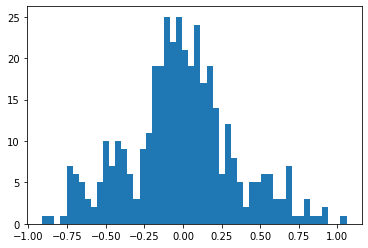

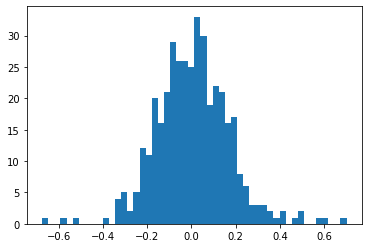

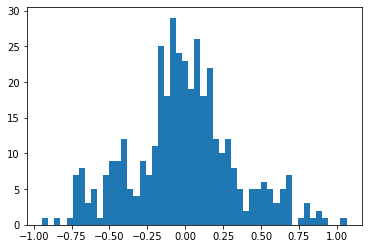

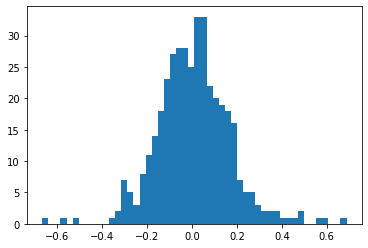

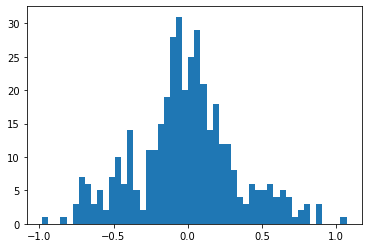

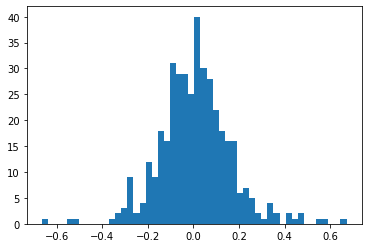

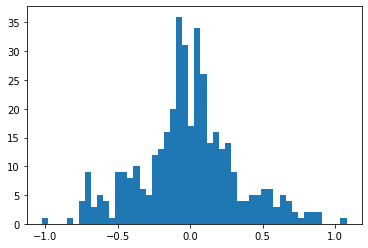

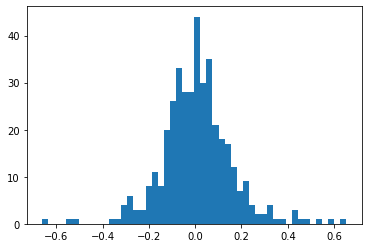

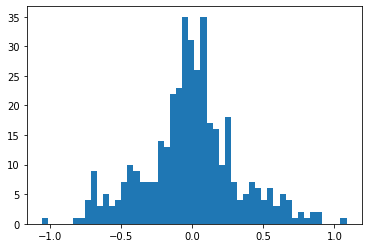

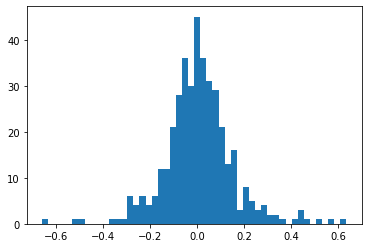

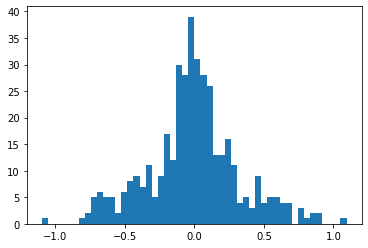

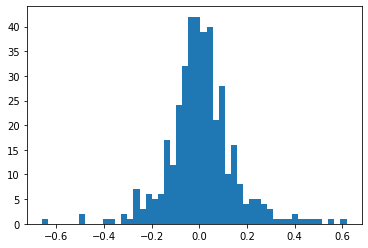

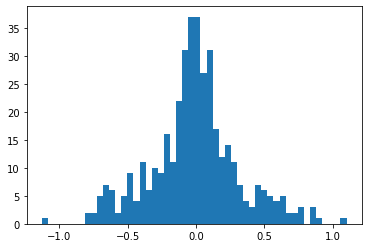

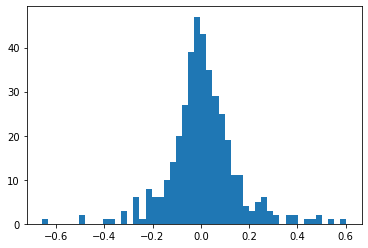

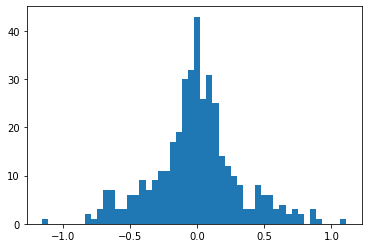

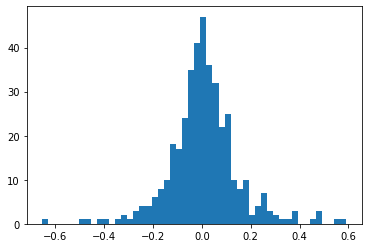

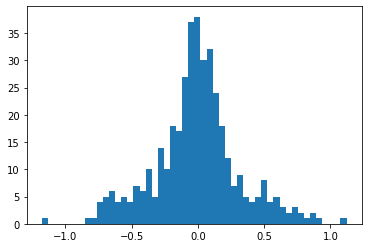

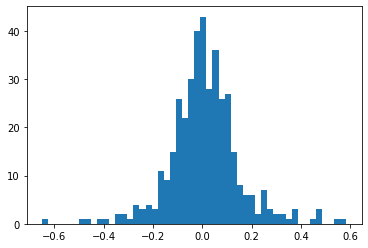

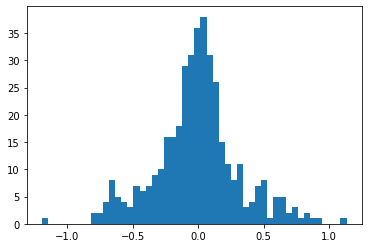

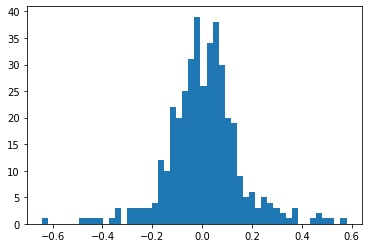

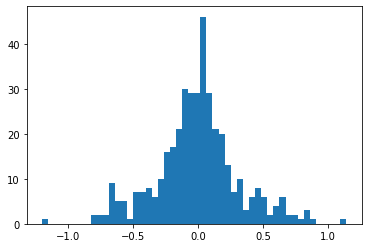

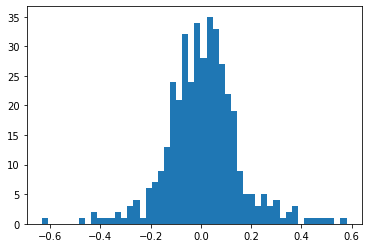

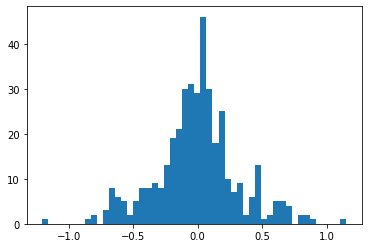

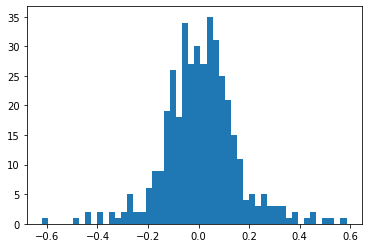

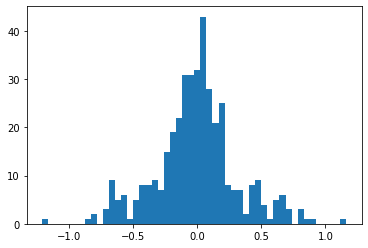

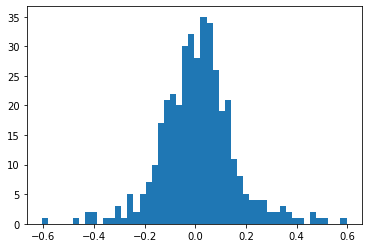

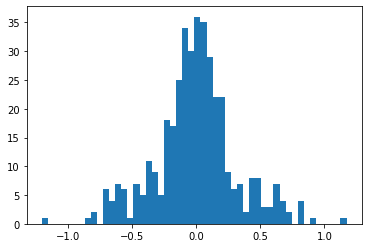

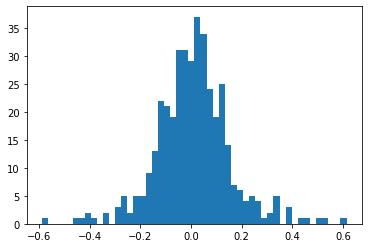

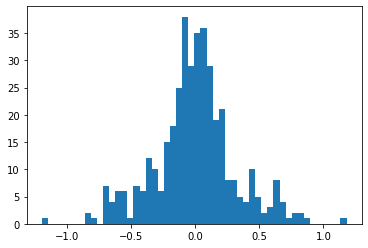

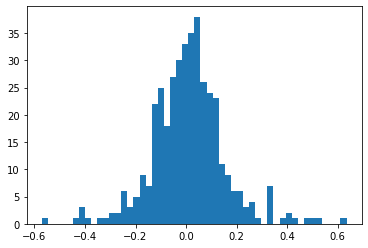

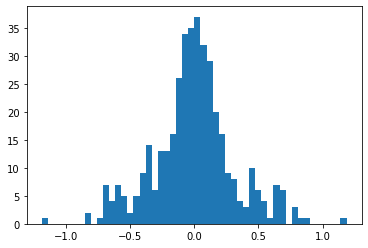

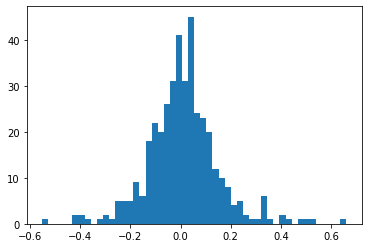

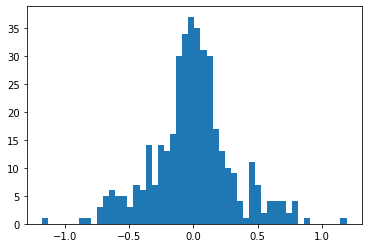

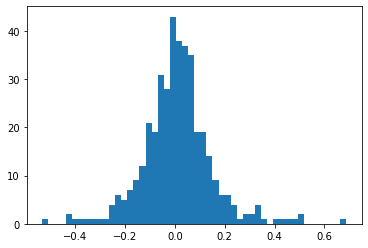

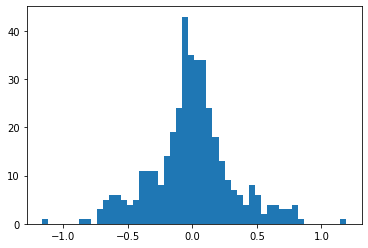

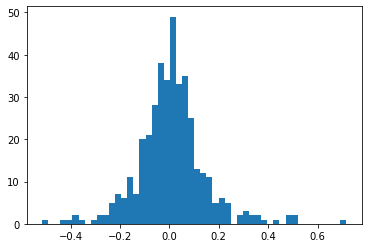

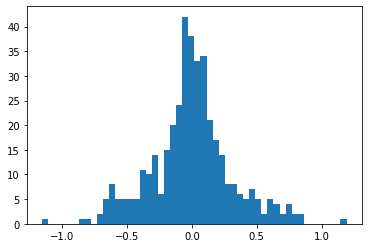

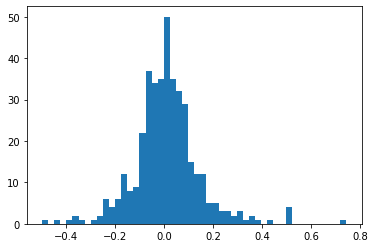

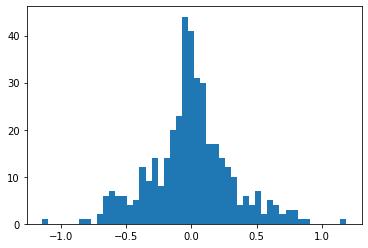

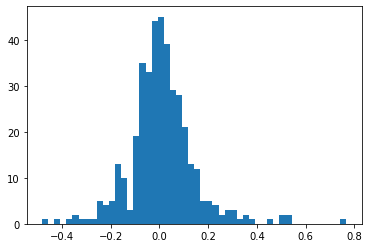

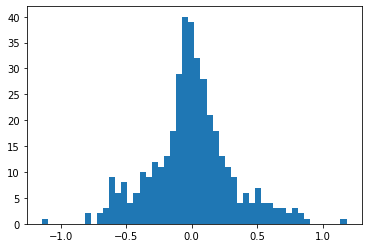

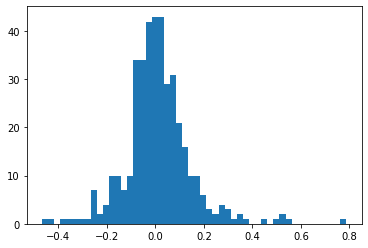

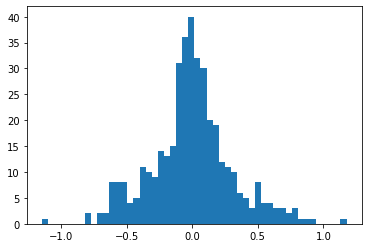

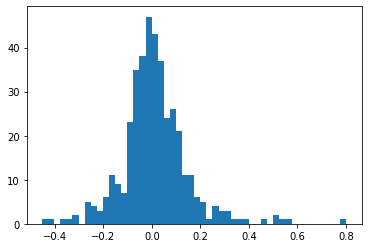

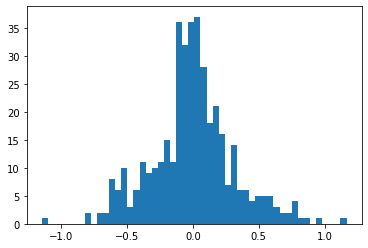

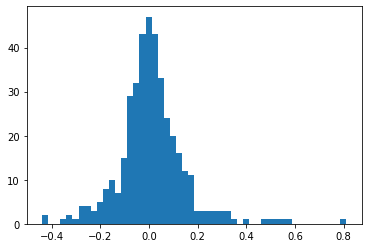

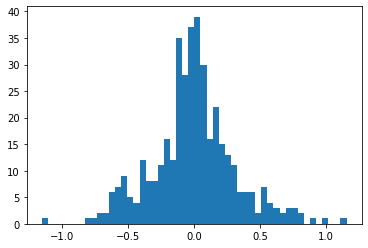

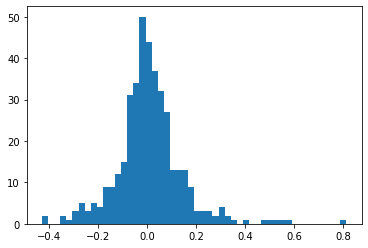

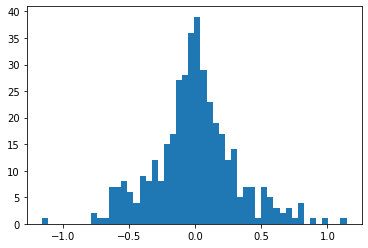

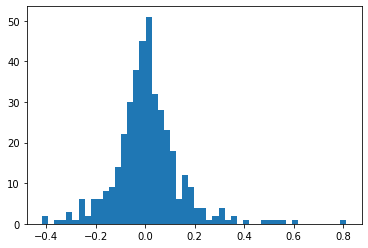

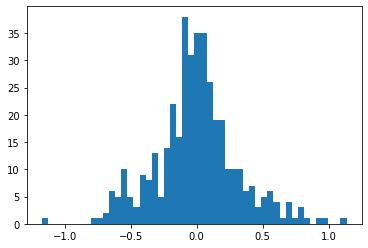

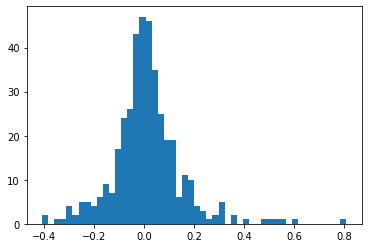

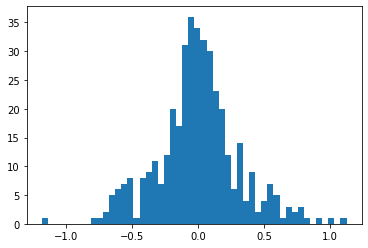

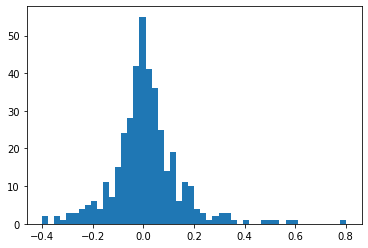

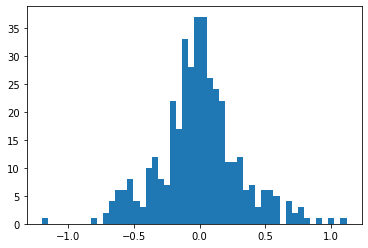

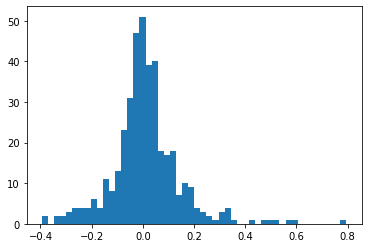

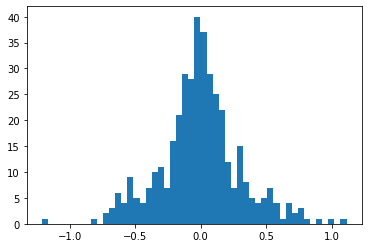

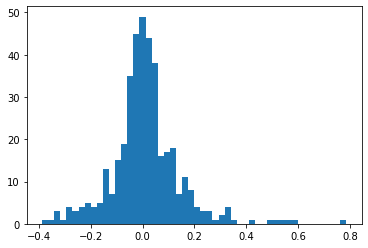

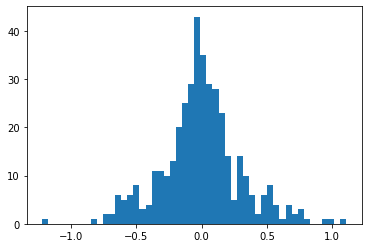

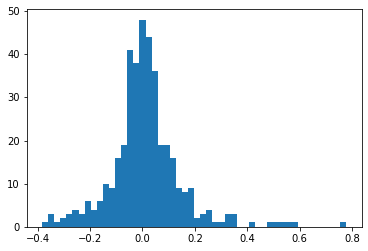

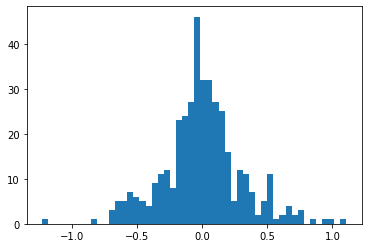

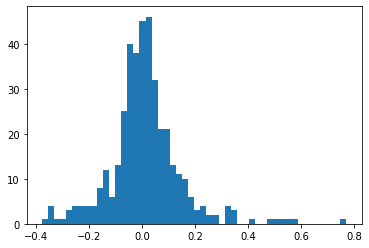

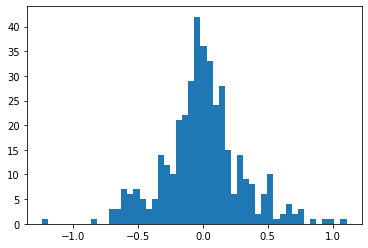

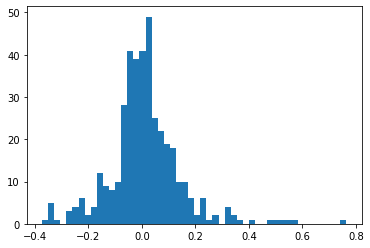

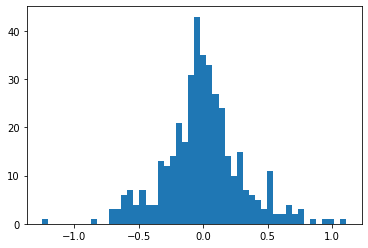

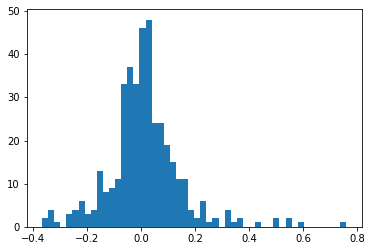

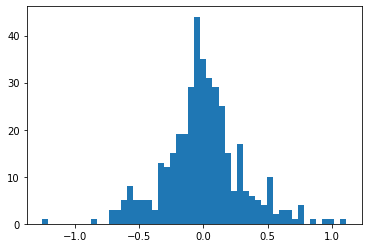

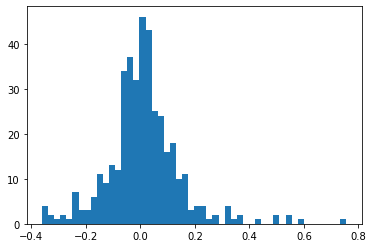

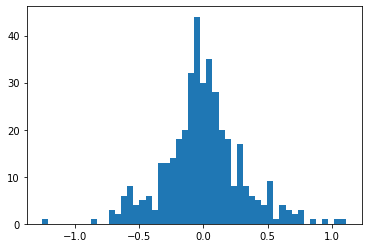

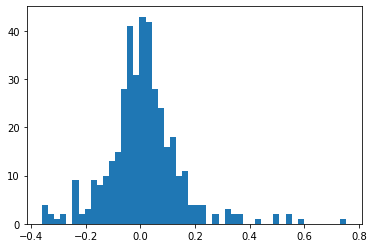

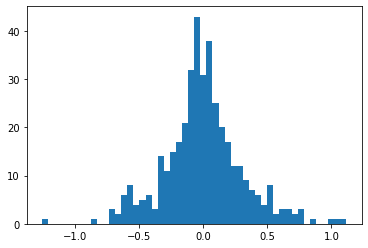

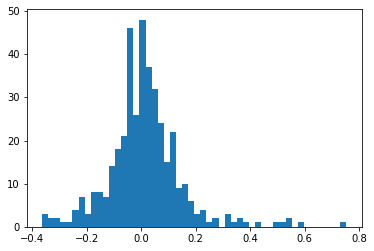

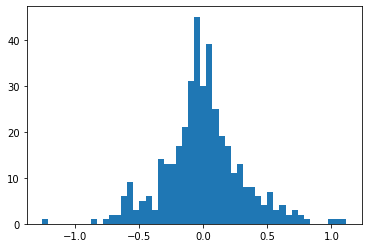

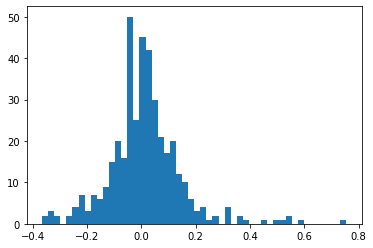

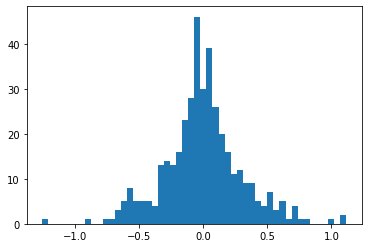

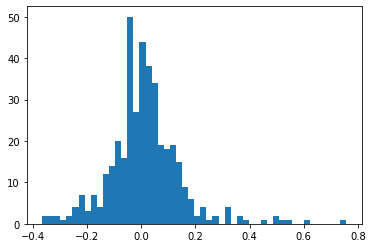

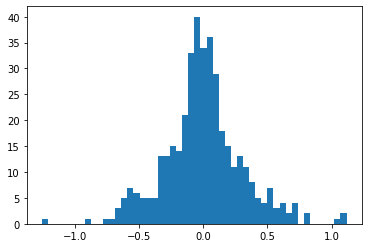

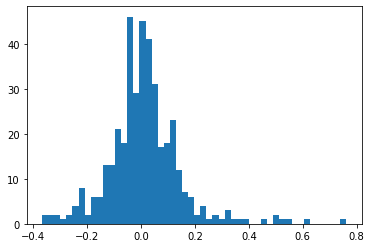

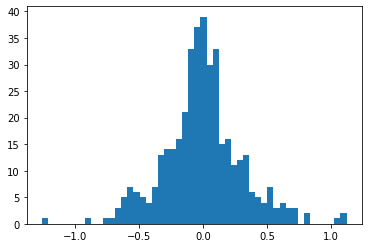

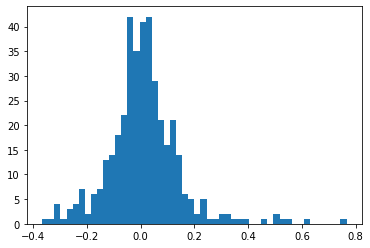

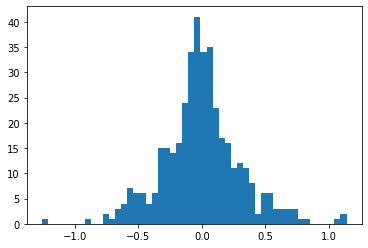

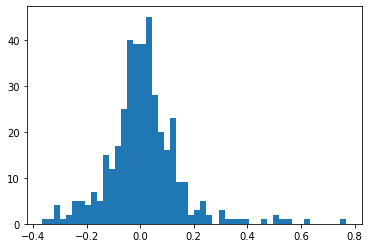

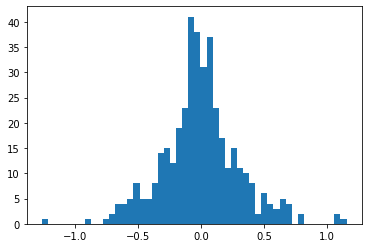

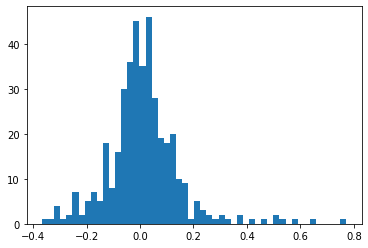

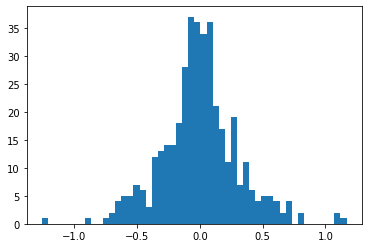

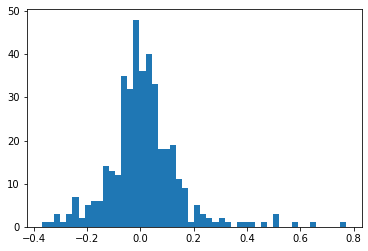

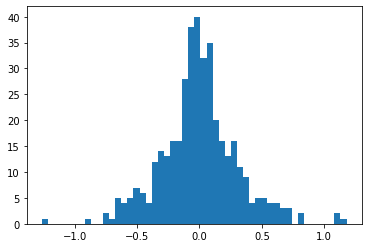

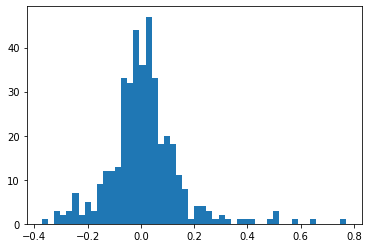

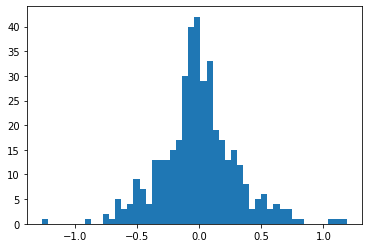

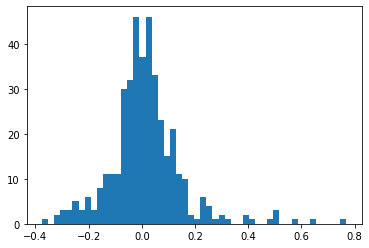

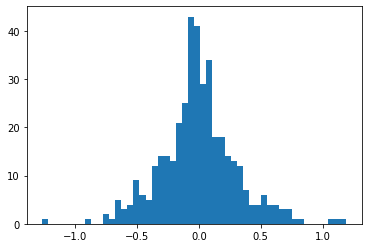

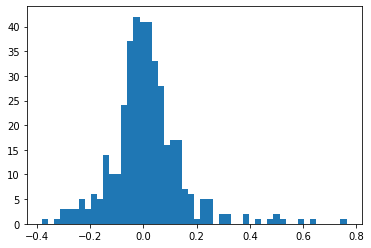

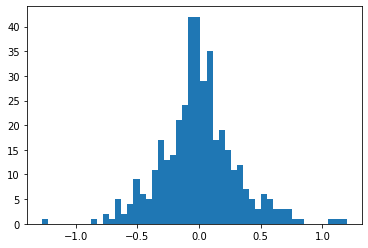

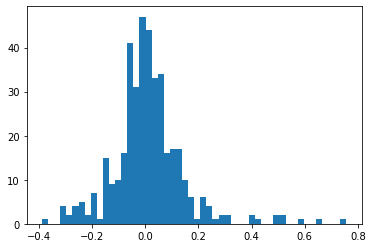

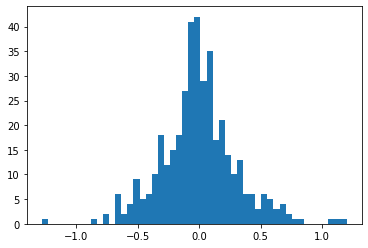

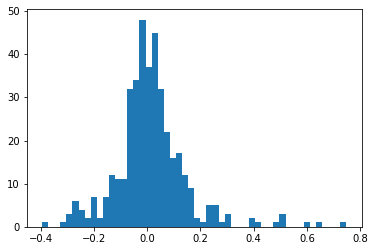

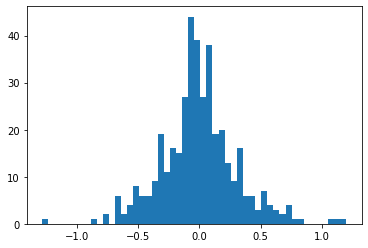

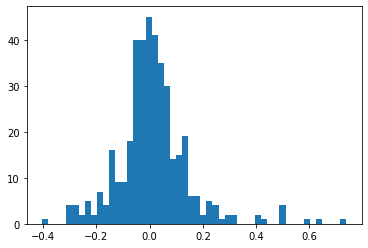

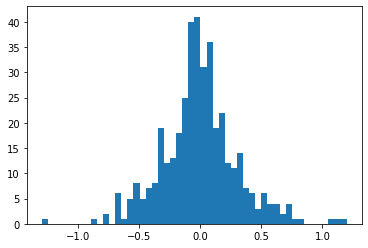

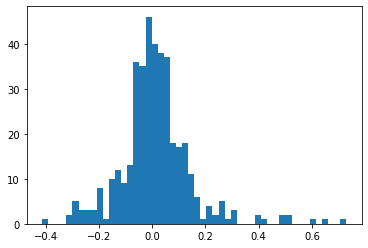

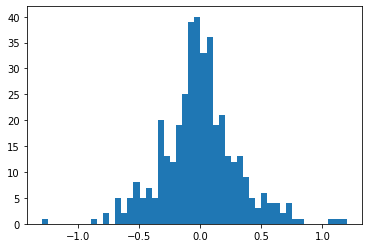

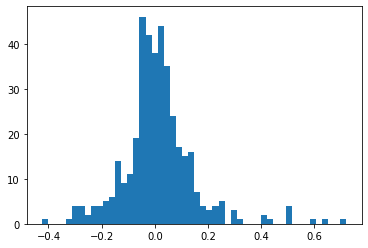

In [16]:
for i in range(len(y_number)):
    numbers = y_number[i]
    plt.hist(numbers.cpu(),bins = 50)
    plt.show()
    plt.close()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
import math
from sympy import init_printing
import scipy.stats as stats
init_printing()

In [18]:
from sympy.abc import theta
from sympy.abc import pi
from sympy.abc import sigma
from sympy.abc import mu
init_printing(use_unicode=True)

In [19]:
m = sympy.symbols('m')
x = sympy.symbols('x')
part1 = sympy.symbols('part1')
part2 = sympy.symbols('part2')
part3 = sympy.symbols('part3')
part4 = sympy.symbols('part4')

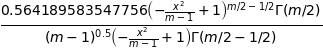

In [20]:
f2 = (1/2)*((1/(m-1)**0.5))*((sympy.gamma(m/2))/(sympy.gamma((m-1)/2)*sympy.gamma(1/2)))*(2/(1-((x**2)/(m-1))))*((1-(x**2/(m-1)))**((m-1)/2))
f2

In [21]:

results2 = []
x_value2 = []
for i in np.arange (-(2-1)**0.5,(2-1)**0.5,(((2-1)**0.5)*2)/100):
    if i == -(2-1)**0.5:
        pass
    else:
        f3 = f2.subs([(m,2),(x,i)])
        results2.append(f3)
        x_value2.append(i)

In [22]:
results3 = []
x_value3 = []
for i in np.arange (-(3-1)**0.5,(3-1)**0.5,(((3-1)**0.5)*2)/100):
    if i == -(3-1)**0.5:
        pass
    else:
        f3 = f2.subs([(m,3),(x,i)])
        results3.append(f3)
        x_value3.append(i)

In [23]:

results4 = []
x_value4 = []
for i in np.arange (-(4-1)**0.5,(4-1)**0.5,(((4-1)**0.5)*2)/100):
    if i == -(4-1)**0.5:
        pass
    else:
        f3 = f2.subs([(m,4),(x,i)])
        results4.append(f3)
        x_value4.append(i)

In [24]:
results10 = []
x_value10 = []
for i in np.arange (-(10-1)**0.5,(10-1)**0.5,(((10-1)**0.5)*2)/100):
    if i == -(10-1)**0.5:
        pass
    else:
        f3 = f2.subs([(m,10),(x,i)])
        results10.append(f3)
        x_value10.append(i)

In [25]:
results29 = []
x_value29 = []
for i in np.arange (-(29-1)**0.5,(29-1)**0.5,(((29-1)**0.5)*2)/100):
    if i == -(29-1)**0.5:
        pass
    else:
        f3 = f2.subs([(m,29),(x,i)])
        results29.append(f3)
        x_value29.append(i)

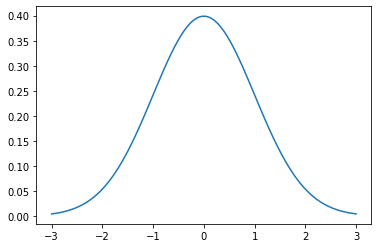

In [60]:
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

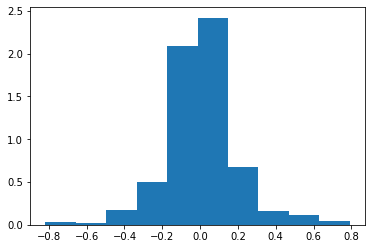

In [39]:
numbers = y_number[59]
weights = np.ones_like(numbers.cpu())/len(numbers.cpu())
plt.hist(numbers.cpu(), weights= weights,density=1,bins = 10)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

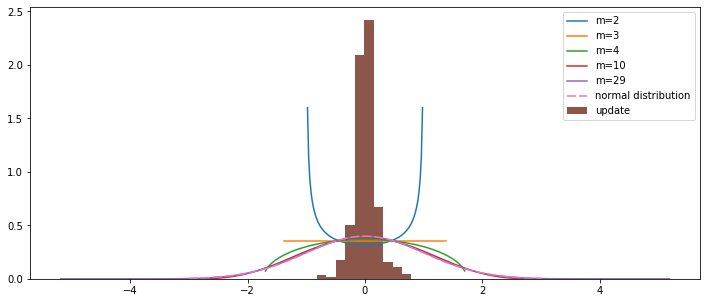

In [62]:

plt.figure(figsize=(12,5))
plt.plot(x_value2,results2,label="m=2")
plt.plot(x_value3,results3,label="m=3")
plt.plot(x_value4,results4,label="m=4")
plt.plot(x_value10,results10,label="m=10")
plt.plot(x_value29,results29,label="m=29")
plt.hist(numbers.cpu(), weights= weights,bins = 10,density=1,label = "update")
#plt.plot(x_value100,results100,label="m=100")
plt.plot(x, stats.norm.pdf(x, mu, sigma),dashes=[6,2],label="normal distribution")
plt.legend()
plt.show